In [146]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.models import Sequential, Model 
from keras.layers import Dense, Input
from keras import losses
import keras.backend as K

## Make data: monotonic/convex base functions with ripple and noise

In [326]:
def base(x, y): 
    # Plane, monotonic along each dimension
    # return 5*x - 5*y    
    
    # 2D sigmoid, also monotonic along each dimension
    return 1/(1 + np.exp(50*(x - 0.5)*(y - 0.5)))

    # Paraboloid
    #return (2*(x-0.5))**2 + (2*(y-0.5))**2

def ripple(x, y):
    return np.sin(30 * x) - np.cos(30 * y) 

m = 2       # number of dimensions
nd = 100    
n = nd*nd   # total number of samples

x_axis = np.linspace(0, 1, nd)
y_axis = np.linspace(0, 1, nd)

X, Y = np.meshgrid(x_axis, y_axis)
Z0 = base(X, Y)                                 # make a base
Z1 = Z0 + 0.2 * ripple(X, Y)                    # add ripple
Z = Z1 + np.random.normal(0, 0.2, (nd, nd))     # add noise

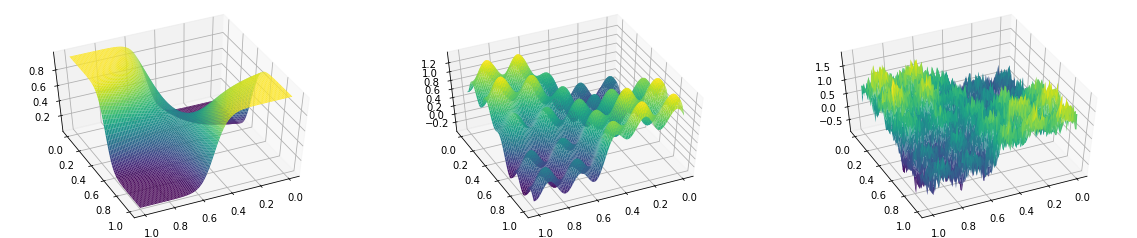

In [327]:
fig = plt.figure(figsize=(20, 4)) 

ax1 = plt.subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z0, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.view_init(50, 65)

ax2 = plt.subplot(132, projection='3d')
ax2.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.view_init(50, 65)

ax3 = plt.subplot(133, projection='3d')
ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax3.view_init(50, 65)

plt.show()

In [328]:
x = np.transpose(np.vstack([X.flatten(), Y.flatten()]))
y = Z.flatten() 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

## Make a model: dense NN for regression with a sufficently high capacity to capture the curvature of the ripple

In [349]:
def create_model():
    inputs = Input(shape=(np.shape(x_train)[1],))
    layer1 = Dense(128, activation='relu')(inputs)
    layer2 = Dense(64, activation='relu')(layer1)
    predictions = Dense(1, activation='linear')(layer2)
    return (Model(inputs=inputs, outputs=predictions), inputs)

## Baseline: regular model fitting

In [351]:
model, inputs = create_model()

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error']) 
history = model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.04795739290118217
Test accuracy: 0.17530982398986816


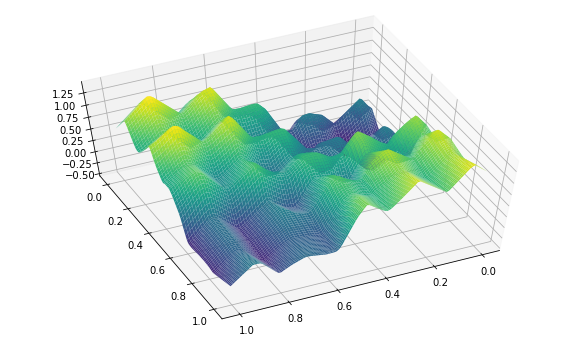

In [352]:
z_pred = model.predict(x).reshape((nd, nd))

fig = plt.figure(figsize=(10, 6)) 
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.view_init(60, 65)
plt.show()

## Enforce monotonicity: add a regularizer that decreases when all output gradients wrt input have the same sign (in the minibatch) and increases otherwise  

In [387]:
def custom_loss(model, input_tensor):
    def loss(y_true, y_pred):
        
        grads = K.gradients(model.output, model.input)[0] 
        #sess = K.get_session()
        #results = sess.run(grads, feed_dict={model.input: input_tensor})
        
        #loss_f = losses.mean_squared_error(y_true, y_pred) + 0.8 * K.exp( - K.square(K.sum(grads)))
        loss_f = losses.mean_squared_error(y_true, y_pred) + 0.8 * K.exp( - K.sum(K.square(K.sum(K.softsign(grads), axis=0))))
        
        return loss_f
   
    return loss

model_reg, inputs_reg = create_model()
model_reg.compile(optimizer='adam', loss=custom_loss(model_reg, inputs_reg), metrics=['mean_absolute_error'])
history = model_reg.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0, validation_data=(x_val, y_val)) 
score = model_reg.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.08392420428991318
Test accuracy: 0.23283976650238036


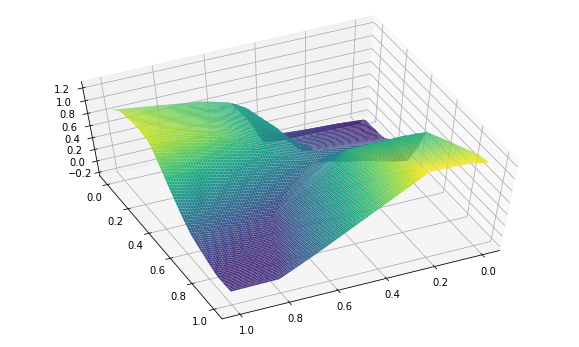

In [388]:
z_pred = model_reg.predict(x).reshape((nd, nd))

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.view_init(60, 65)
plt.show()